In [1]:
%pprint

Pretty printing has been turned OFF


## 2016 Election Project 
### Part 2 of Processing Pipeline

This notebook is intended to document NER annotation of my data throughout this project. The data I am starting out with are transcripts of the presidential debates from the 2016 US Election- the 10 Democratic primary debates, the 12 Republican primary debates, and the debates for the general election between Hillary Clinton and Donald Trump. The transcripts were taken from UCSB's American Presidency Project. The citations for these transcripts can be found in the README.

In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import re
import pickle

**I'm going to create a mapping function that will take the sentence in each row of each data frame and perform nltk's chunking operation on it to get a tree with annoted NEs**

In [3]:
#Import the saved list of data frames I created in secondary_data_processing
import pickle
f = open('/Users/Paige/Documents/Data_Science/dataframes_list.p', 'rb')
dataframes = pickle.load(f)
f.close()

In [4]:
def get_tree(sent):
    sents = nltk.sent_tokenize(sent)
    words = [nltk.word_tokenize(sent) for sent in sents]
    pos = [nltk.pos_tag(sent) for sent in words]
    chunk = nltk.ne_chunk_sents(pos)
    return list(chunk)[0]

In [5]:
master_df = pd.concat(dataframes)

In [6]:
master_df = master_df.reset_index(drop=True)

In [7]:
master_df.head()

,Date,Debate Type,Speaker,Sents
0,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...
1,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...
2,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo..."
3,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...
4,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h..."


In [8]:
master_df.tail()

,Date,Debate Type,Speaker,Sents
37059,9-26-16,general,HOLT,The conversation will continue.
37060,9-26-16,general,HOLT,A reminder.
37061,9-26-16,general,HOLT,The vice presidential debate is scheduled for ...
37062,9-26-16,general,HOLT,My thanks to Hillary Clinton and to Donald Tru...
37063,9-26-16,general,HOLT,"Good night, everyone."


In [9]:
master_df['Tree']=master_df.Sents.map(get_tree)

In [10]:
master_df.head()

,Date,Debate Type,Speaker,Sents,Tree
0,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...,"[(It, PRP), (is, VBZ), (9:00, CD), (p.m., NN),..."
1,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...,"[(Welcome, VB), (to, TO), (the, DT), (sixth, J..."
2,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo...","[(I, PRP), ('m, VBP), [(Neil, JJ), (Cavuto, NN..."
3,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...,"[(Tonight, NN), (we, PRP), (are, VBP), (workin..."
4,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h...","[(And, CC), (according, VBG), (to, TO), [(Face..."


**I've created an NER tree! Notice that nltk's chunker pulled out Neil Cavuto and Maria Bartiromo as people. Now I want to change the S label at the top of the tree to represent who said this utterence using the information in the Speaker column.**

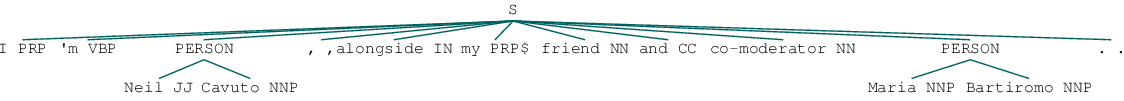

In [11]:
master_df.iloc[2][-1]

In [12]:
#Using mapping involving 2 columns. Use the Speaker column to modify the Tree column.
for row in range(0, len(master_df)):
    master_df.iloc[row][-1].set_label(master_df.iloc[row][2])

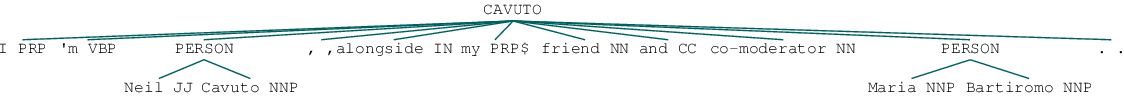

In [13]:
master_df.iloc[2]['Tree']

In [14]:
master_df.iloc[2]['Speaker']

'CAVUTO'

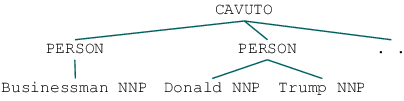

In [15]:
#Uh oh. The good news is the chunker got Trump's title- Businessman. The bad news is it's separated from the rest of his name. I'll have to fix that.
master_df.iloc[8]['Tree']

In [16]:
master_df.iloc[8]['Speaker']

'CAVUTO'

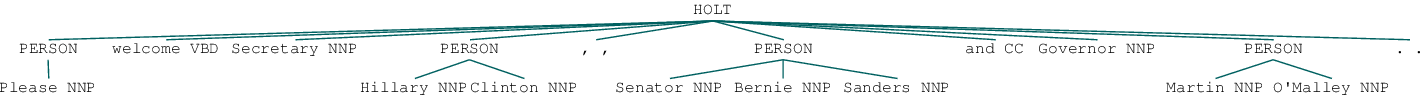

In [17]:
#Again, it got Hillary Clinton and Martin O'Malley, but missed Secretary and Governor, but it DID get Senator Bernie Sanders
master_df.iloc[1603]['Tree']

In [18]:
master_df.iloc[1603]['Speaker']

'HOLT'

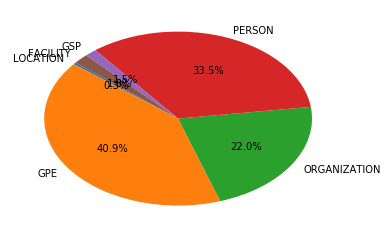

In [19]:
#This section is with help from a datacamp tutorial
#https://campus.datacamp.com/courses/natural-language-processing-fundamentals-in-python/named-entity-recognition?ex=3

ner_categories = defaultdict(int)

# Create the nested for loop
for tree in master_df['Tree']:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())

# Create a list of the values: values
values = [ner_categories.get(l) for l in labels]

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()

In [20]:
people = []
for tree in master_df['Tree']:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'PERSON':
                people.append(chunk)

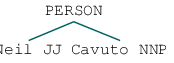

In [21]:
people[1]

In [22]:
people[1].leaves()[0][0]
words = [leaf[0] for leaf in people[1].leaves()]
words

['Neil', 'Cavuto']

In [23]:
people_names = []
name = ''
for tree in people:
    for leaf in tree.leaves():
        name+=' '+str(leaf[0])
    people_names.append(name.strip())
    name = ''


In [24]:
names = set(people_names)
list(names)[100:200]

['Enough', 'Senator Ted Cruz', 'Sidney Blumenthal', 'Dewayne', 'Qaida', 'Forbes', 'Sweden', 'Darnell Ishmel', 'Celeste Arrarás', 'ISIS', 'Krispy Kremes', 'Ronald', 'Lake Erie', 'Kudlow', 'Mary Katharine', 'Webb', 'Mary Katherine Ham', 'Aleppo', 'Moines NAACP', 'Alright', 'Selective Service', 'William', 'Soros', 'Joe Arpaio', 'Had', 'Kenya', 'Liberman', 'Eric', 'Qaeda', 'John Kennedy', 'Listen', 'Super PAC', 'Roberts', 'Sidney', "Martin O'Malley", 'Charlie', 'Mark Zuckerburg', 'Josh Jacob', 'Sean', 'Sheriff', 'Furious', 'Carla', 'Nancy Reagan', 'Budget Committee', 'Eric Garner', 'Nevada', 'Heidi', 'Kim Davis', 'Chase Norton', 'Costco', 'Mr. Assad', 'Harry Reid', 'Charleston', 'Kuwait', 'Bushes', 'Bobby Jindal', 'Brian Carlson', 'Bret Baier', 'Hang', 'Dulce', 'Debbie Wasserman Schultz', 'Francisco', 'Pataki', 'Alexis Kulash', 'Lucia', 'Veterans', 'Carolina', 'Carrier Corporation', 'Candy Crush', 'Deborah Wasserman Schultz', 'Cuomo', 'Florida Senator Marco Rubio', 'Mark Watson', 'Hispanic

In [25]:
len(names)

1133

**Notice we're missing a good amount of titles in this list.**

In [26]:
'Senator' in names

True

In [27]:
'Governor' in names

False

In [28]:
'Mr.' in names

True

In [29]:
'Mrs.' in names

False

In [30]:
'Miss' in names

False

In [31]:
'Doctor' in names

True

In [32]:
'President' in names

False

In [33]:
'Secretary' in names

False

In [34]:
'Sir' in names

True

In [35]:
'Madame' in names

True

**I'm going to go through all of these tags by hand, and link them to who they are referring to. I will create a dictionary of NEs. The expression that was used will be the key, and the person it refers to will be the value. I think copying and pasting this set and deleting things that obviously are not people by hand first will speed things up.**

In [36]:
#f = open('/Users/Paige/Documents/Data_Science/names.txt', 'w')
#for name in names:
#    f.write(str(name)+'\n')
#f.close()

**I'm going to read in the text file I made and turn it into the dictionary described above. In this linked.txt file, I removed everyone except for the most relevant people including leaders of countries, all of the candidates, all of the moderators, and people involved in the events discussed during the debate. If the chunker only pulled out a title like 'Madame', it was tagged as TITLE to be resolved later. If the title was a part of the chunk, obviously it was included and mapped to whoever it referred to. Titles that clearly could only refer to one of the relevant people, like Secretary, were mapped to their respective entity. Other "names" like Lady Liberty and Mr. Average were mapped to NICKNAME unless I knew right away who was being referred to.**

In [37]:
with open('/Users/Paige/Documents/Data_Science/2016-Election-Project/data/Lists/linked.txt') as f:
    name_link = f.readlines()

In [38]:
#I considered 384 NEs to be relevant to the debates.
len(name_link)

384

In [39]:
name_link[:20]

['Sean Hannity;Sean Hannity\n', 'Sean;Sean Hannity\n', 'Hannity;Sean Hannity\n', 'Jake Tapper;Jake Tapper\n', 'Tapper;Jake Tapper\n', 'Jake;Jake Tapper\n', 'Florida Senator;Marco Rubio\n', 'Hill;Hillary Clinton\n', 'Hey Ted;Ted Cruz\n', 'Bibi Netanyahu;Benjamin Netanyahu\n', 'Mr. Cruz;Ted Cruz\n', 'Ted;Ted Cruz\n', 'Cruz;Ted Cruz\n', 'Bret;Bret Baier\n', 'Baier;Bret Baier\n', 'John Quincy Adams;John Quincy Adams\n', 'Yasser Arafat;Yasser Arafat\n', 'Rubio;Marco Rubio\n', 'Marco;Marco Rubio\n', 'Bobby Jindal;Bobby Jindal\n']

In [40]:
links = [x.strip().split(';') for x in name_link]
links[30:50]

[['Mayor Giuliani', 'Rudy Giuliani'], ['Giuliani', 'Rudy Giuliani'], ['Rudy', 'Rudy Giuliani'], ['Miss Piggy', 'Alicia Machado'], ['Snowden', 'Edward Snowden'], ['Malley', "Martin O'Malley"], ["O'Malley", "Martin O'Malley"], ['Martin', "Martin O'Malley"], ['Martha', 'Martha Raddatz'], ['Raddatz', 'Martha Raddatz'], ['Dana', 'Dana Bash'], ['Hillary Rodham', 'Hillary Clinton'], ['John Mccain', 'John McCain'], ['McCain', 'John McCain'], ['Senator Lindsey Graham', 'Lindsey Graham'], ['Lindsey', 'Lindsey Graham'], ['Graham', 'Lindsey Graham'], ['Barbara Bush', 'Barbara Bush'], ['Lyndon Johnson', 'Lyndon Johnson'], ['Martin', "Martin O'Malley"]]

In [41]:
link_dict = {x[0]:x[1] for x in links}

In [42]:
f = open('/Users/Paige/Documents/Data_Science/link_dict.pkl', 'wb')
pickle.dump(link_dict, f, -1)
f.close()

In [43]:
#This is the set of all of the relevant people who were referred to in the debates.
set(link_dict.values())

{'Calvin Coolidge', 'George W. Bush', 'Bashar al-Assad', 'Mitt Romney', 'Vladimir Putin', 'Merrick Garland', 'TITLE', 'Jeff Sessions', 'Frederick Douglas', 'Ken Bone', 'Hillary Clinton', 'Paul Ryan', 'Nelson Mandela', 'Mitch McConnell', 'Al Gore', 'David Duke', 'Rush Limbaugh', 'Chris Christie', 'Michael Brown', 'Bill Clinton', 'Chuck Schumer', 'Freddie Gray', 'Hugh Hewitt', 'Major Garrett', 'Ashraf Ghani', 'Jorge Ramos', 'Carl Quintanilla', 'John Quincy Adams', 'Eric Trump', 'Kim Jong Un', 'Joseph Stalin', 'John Boehner', 'Adolf Hitler', 'Nancy Pelosi', 'Thomas Jefferson', 'Richard Nixon', 'Michael Bloomberg', 'Martha Raddatz', 'Michelle Obama', 'Rosa Parks', 'Wolf Blitzer', 'Jeb Bush', 'Woodrow Wilson', 'John Kasich', "Tip O'Neill", 'Saddam Hussein', 'John McCain', 'Rick Santorum', 'Jake Tapper', 'Jim Webb', 'Sonia Sotomayor', 'Nikki Haley', 'Dwight Eisenhower', 'Winston Churchill', 'Lyndon Johnson', 'Michael Flynn', "Rosie O'Donnell", 'Andrea Mitchell', 'Pope Francis', 'James Comey'

In [44]:
#Here are some of the ways those people were referred to.
list(link_dict.keys())[:40]

['Sean Hannity', 'Sean', 'Hannity', 'Jake Tapper', 'Tapper', 'Jake', 'Florida Senator', 'Hill', 'Hey Ted', 'Bibi Netanyahu', 'Mr. Cruz', 'Ted', 'Cruz', 'Bret', 'Baier', 'John Quincy Adams', 'Yasser Arafat', 'Rubio', 'Marco', 'Bobby Jindal', 'Andrea', 'Ohio Governor', 'Deborah Wasserman Schultz', 'Ted Cruz', 'Barak Obama America', 'Jim', 'Webb', 'Shultz', 'Fiorina', 'Carly', 'Mayor Giuliani', 'Giuliani', 'Rudy', 'Miss Piggy', 'Snowden', 'Malley', "O'Malley", 'Martin', 'Martha', 'Raddatz']

In [45]:
link_dict['Ohio Governor']

'John Kasich'

In [46]:
link_dict['Senator']

'TITLE'

In [47]:
link_dict['Andrea']

'Andrea Mitchell'

In [48]:
link_dict['Senator Webb']

'Jim Webb'

In [49]:
link_dict['Hilary Clinton']

'Hillary Clinton'

In [50]:
link_dict['Hillary Clinton']

'Hillary Clinton'

In [51]:
link_dict['Senator Bernie Sanders']

'Bernie Sanders'

In [52]:
link_dict['Christie']

'Chris Christie'

In [53]:
link_dict['Mr. Trump']

'Donald Trump'

In [54]:
master_df.loc[8421]['Tree'][0]

('Senator', 'NNP')

**I also want to find REs that were just completely missed by the chunker. To tag RE's that were completely missed, I am first going to go through and look for relevant last names. I will tag those as the respective person. Then, I am going to run the process that I did above, pulling in titles and first names into the new subtree I just created.**

In [55]:
last_names = list(set(link_dict.values()))
last_names = [x.split() for x in last_names]
#Since all of the relevant people only have a two token name except for one of the moderators, Maria Celeste Arraras, and
#Debbie Wasserman Shultz, I'm just going to look for a single token, the last name.
last_names = [x[-1] for x in last_names]
last_names = set(last_names)
last_names

{'Parks', 'Arpaio', 'Todd', 'Jong-Un', 'Gray', 'TITLE', 'Graham', 'Roosevelt', 'Obama', 'Warren', 'Reagan', 'Wallace', 'Rice', 'Mandela', 'Mitchell', 'Paul', 'Tapper', 'Santorum', 'Roof', 'Flynn', 'Putin', 'Quintanilla', 'Carter', 'McCain', 'Jefferson', 'Eisenhower', 'Huckabee', 'Raddatz', 'Kerry', 'Wilson', 'Duke', 'Brown', 'Strassel', 'Garner', 'Comey', 'Scalia', 'Haley', 'Davis', 'Machado', 'Netanyahu', 'Mattis', 'Bush', 'Adams', 'Franklin', 'Giuliani', 'Fiorina', 'Salinas', 'Boehner', 'Hitler', 'Ryan', "O'Malley", 'Hannity', 'Kasich', 'Carson', 'Gaddafi', 'Stalin', 'Douglas', 'Jindal', 'Un', 'Bloomberg', 'Podesta', 'Webb', 'Hewitt', 'Francis', 'Trump', 'Blitzer', 'Limbaugh', 'Bone', 'Sanders', 'Arraras', 'Sessions', 'Maddow', "O'Donnell", 'Abdullah', 'Bland', 'Snowden', 'Pelosi', 'Mubarak', 'Clinton', 'Merkel', 'Garland', 'Cuomo', 'Garrett', 'Kennedy', 'Schumer', 'Romney', 'Schultz', 'Coolidge', 'Kelly', 'Nixon', 'Daqneesh', 'Cavuto', 'Hussein', 'Biden', 'Christie', 'Sotomayor', 'H

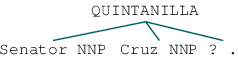

In [56]:
master_df.loc[8421]['Tree']

In [57]:
#This loop looks for REs that should have been tagged as stand alone REs, but were missed
for tree in master_df['Tree']:
    for t in tree:
        if type(t) == tuple:
            if t[0] in last_names:
                tree[tree.index(t)] = nltk.tree.Tree('PERSON', [t])

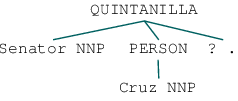

In [58]:
master_df.loc[8421]['Tree']

**Now I need to use this dictionary to label all of the named entities in my NER trees with who the NE is referring to instead of just PERSON or GPE, etc.**

In [59]:
def name_linking(tree):
    name = ''
    for chunk in tree:
        #Look for relevent names with ANY label. Maybe "Hillary Clinton" was mistakenly tagged as a GPE
        if hasattr(chunk, 'label'):
            for leaf in chunk.leaves():
                name+=' '+str(leaf[0])
            if name.strip() in link_dict.keys():
                name = name.strip()
                chunk.set_label(link_dict[name])
                name = ''
            else:
                name = ''
    return tree

In [60]:
master_df['Tree'] = master_df.Tree.map(name_linking)

In [61]:
master_df.head()

,Date,Debate Type,Speaker,Sents,Tree
0,1-14-16,primary_rep,CAVUTO,It is 9:00 p.m. here at the North Charleston ...,"[(It, PRP), (is, VBZ), (9:00, CD), (p.m., NN),..."
1,1-14-16,primary_rep,CAVUTO,Welcome to the sixth Republican presidential o...,"[(Welcome, VB), (to, TO), (the, DT), (sixth, J..."
2,1-14-16,primary_rep,CAVUTO,"I'm Neil Cavuto, alongside my friend and co-mo...","[(I, PRP), ('m, VBP), [(Neil, JJ), (Cavuto, NN..."
3,1-14-16,primary_rep,BARTIROMO,Tonight we are working with Facebook to ask t...,"[(Tonight, NN), (we, PRP), (are, VBP), (workin..."
4,1-14-16,primary_rep,BARTIROMO,"And according to Facebook, the U.S. election h...","[(And, CC), (according, VBG), (to, TO), [(Face..."


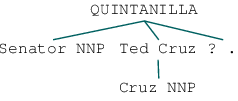

In [62]:
master_df.loc[8421]['Tree']

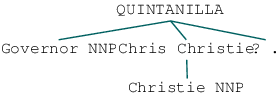

In [63]:
master_df.loc[8430]['Tree']

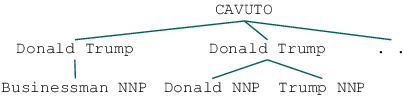

In [64]:
master_df.iloc[8][-1]

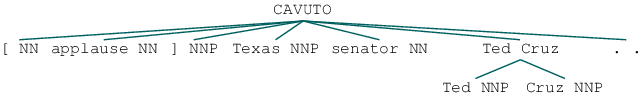

In [65]:
master_df.iloc[9][-1]

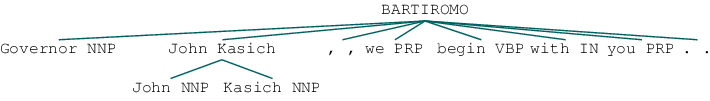

In [66]:
master_df.iloc[1509][-1]

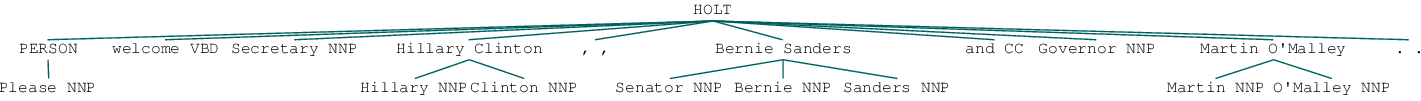

In [67]:
master_df.iloc[1603][-1]

**Next, I'm going to fix up some of the tagging to include titles and any first names that might have been missed. NLTK's RE chunker is supposed to remove titles like Mr., Senator, Mrs., etc. and those are the very things I'm looking for! Luckily, it doesn't always do this well, so some of those titles are included in the tagged trees already, but I'm going to go through and try to add back the missing titles. First, I'm going to create a list of titles and first names. Then, I'm going to cycle through all of the trees that refer to people, look at the word preceeding the tagged chunk, and if that world is a title, I'm going to pull it into the tagged chunk.**

In [69]:
#Here, I'm creating a list of first names of all of the relevant people in the corpora so I can pull these first names
#into the correct label if they were mistakenly left untagged.

first_names = list(set(link_dict.values()))
first_names = [x.split() for x in first_names]
first_names = [x[0] for x in first_names]
first_names = set(first_names)

In [70]:
titles = ['Mr.', 'Mister', 'Lady', 'Speaker', 'Mrs.', 'Miss', 'Madame', 'Sir', 'President', 'Senator', 'Governor', 'Secretary', 'Congressman', 'Dr.', 'Doctor', 'Sheriff', 'Chairman']

titles.extend(first_names)
#The following is a list of ways you can refer to a person that might not be followed by a name. I'm going to look for any
#of these that were missed as well.
re = ['Secretary', 'Governer', 'Congressman', 'Senator', 'Sir', 'Madame', 'Doctor', 'Dr.']
#Need a list of last names and a list of first names
titles

['Mr.', 'Mister', 'Lady', 'Speaker', 'Mrs.', 'Miss', 'Madame', 'Sir', 'President', 'Senator', 'Governor', 'Secretary', 'Congressman', 'Dr.', 'Doctor', 'Sheriff', 'Chairman', 'Chris', 'Lyndon', 'Pope', 'Rudy', 'Yasser', 'Nelson', 'TITLE', 'Frederick', 'Bernie', 'Lindsey', 'Hosni', 'Sandra', 'Ken', 'Anderson', 'Merrick', 'Donald', 'Hillary', 'Bobby', 'Tamir', 'Michael', 'Paul', 'Rachel', 'Senator', 'Abigail', 'Marco', 'Calvin', 'Kim', 'James', 'Martha', 'Carly', 'Freddie', 'Winston', 'Don', 'Mitch', 'Theodore', 'Osama', 'Antonin', 'Mark', 'Jorge', 'Franklin', 'Mitt', 'Deborah', 'Harry', 'Carl', 'Dana', 'Edward', 'Ivanka', 'Fidel', 'Thomas', 'Ronald', 'Mike', 'Andrew', 'Bill', 'Wolf', 'Barack', 'Nancy', 'Omran', 'Eric', 'Benjamin', 'Barbara', 'Sean', 'David', 'John', 'Abdullah', 'Angela', 'Major', 'Alicia', 'Richard', 'Scott', 'Jake', 'Neil', 'Rush', 'Woodrow', 'Elizabeth', 'Hugh', 'Saddam', 'Jeff', 'Adolf', 'Ted', 'Joseph', 'Muammar', 'Alexander', 'Megyn', 'Ben', 'Trayvon', 'Rosa', 'Al',

In [71]:
for tree in master_df['Tree']:
    for chunk in tree:
        i = tree.index(chunk)
        if type(tree[i]) == nltk.tree.Tree:
            #if we find a subtree, and it is a relevant entity, we need to look at the node preceding it
            if tree[i].label() in link_dict.values():
                #if the leaf in front of the subtree is another subtree, and it has the same label or it's labelled 'TITLE'
                #we want to pull it in.
                if type(tree[i-1]) == nltk.tree.Tree and (tree[i-1].label() == tree[i].label() or tree[i-1].label() == 'TITLE'):
                    tree[i] = nltk.tree.Tree(tree[i].label(), list(tree[i-1])+list(tree[i]))
                    tree.remove(tree[i-1])
                if tree[i-1][0] in titles:
                    if i != 0:
                        tree[i].insert(0, tree[i-1])
                        tree.remove(tree[i-1])

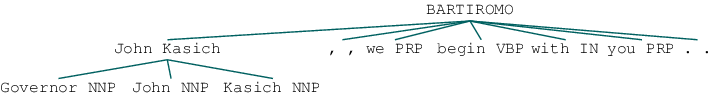

In [72]:
master_df.iloc[1509][-1]

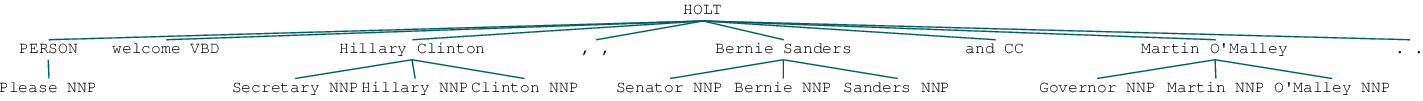

In [73]:
master_df.iloc[1603][-1]

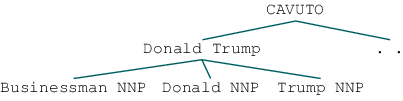

In [75]:
master_df.iloc[8][-1]

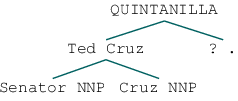

In [76]:
master_df.loc[8421]['Tree']

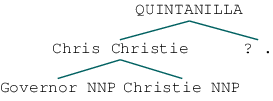

In [77]:
master_df.loc[8430]['Tree']

**Next, I'm going to make sure look for just titles or first names that were missed that stand alone and don't precede a last name using the same method as above.**

In [78]:
#This loop looks for REs that should have been tagged as stand alone REs, but were missed
for tree in master_df['Tree']:
    for t in tree:
        if type(t) == tuple:
            if t[0] in titles:
                tree[tree.index(t)] = nltk.tree.Tree('PERSON', [t])

**And again, I'm going to change the tag of PERSON to the appropriate entity.**

In [79]:
def name_linking(trees):
    name = ''
    for tree in trees:
        for chunk in tree:
            if hasattr(chunk, 'label'):
                if chunk.label() == 'PERSON':
                    for leaf in chunk.leaves():
                        name+=' '+str(leaf[0])
                    if name.strip() in link_dict.keys():
                        name = name.strip()
                        chunk.set_label(link_dict[name])
                        name = ''
                    else:
                        name = ''
    return tree

**Finally, if something was tagged as a PERSON, I've decided I'm going to leave that tag the way it is instead of untagging it, even if it was mistakenly tagged as a person, because I or another researcher might want to go back in the future and look at those other entities. The process of correcting all of them would be very time consuming and not particularly relevant to this project. The entites of importance are tagged and a dictionary of important entities is saved as link_dict.**

In [80]:
##Saving master dataframe to a CSV
master_df.to_csv('/Users/Paige/Documents/Data_Science/2016-Election-Project/data/Debates/csv/master.csv')

In [81]:
f = open('/Users/Paige/Documents/Data_Science/master_df.pkl', 'wb')
pickle.dump(master_df, f, -1)
f.close()